# Some data things I have discovered
* Data types:
    * Historic Glucose mmol/L = automated sensor readings
    * Scan Glucose mmol/L = every time I scan the libre
* They are distinguished by Record Type, 0 for historic, 1 for scan
* I have no idea what Record Type = 6 means, could be some other input data, seems to have no effect on sensor bg readings
* I will only use historic readings for now, as these are collected at regular 15 minute intervals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn')

# Data preparation

In [3]:
data = pd.read_csv('data/SamDysch_glucose_2-5-2022.csv', skiprows=[0])
data.index = pd.to_datetime(data['Device Timestamp'], format="%d-%m-%Y %H:%M")

/home/sdysch/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# drop non-historic glucose records
data = data[data['Record Type'] == 0]

# only keep bg
to_keep = [
    'Historic Glucose mmol/L',
]
data = data[to_keep]

data = data.rename(columns={'Historic Glucose mmol/L': 'reading'})

data.head()

,reading
Device Timestamp,
2019-12-09 19:04:00,6.8
2019-12-09 19:20:00,7.6
2019-12-09 19:35:00,7.7
2019-12-09 19:50:00,7.2
2019-12-09 20:05:00,5.8


In [5]:
# drop NaNs
data = data.dropna()

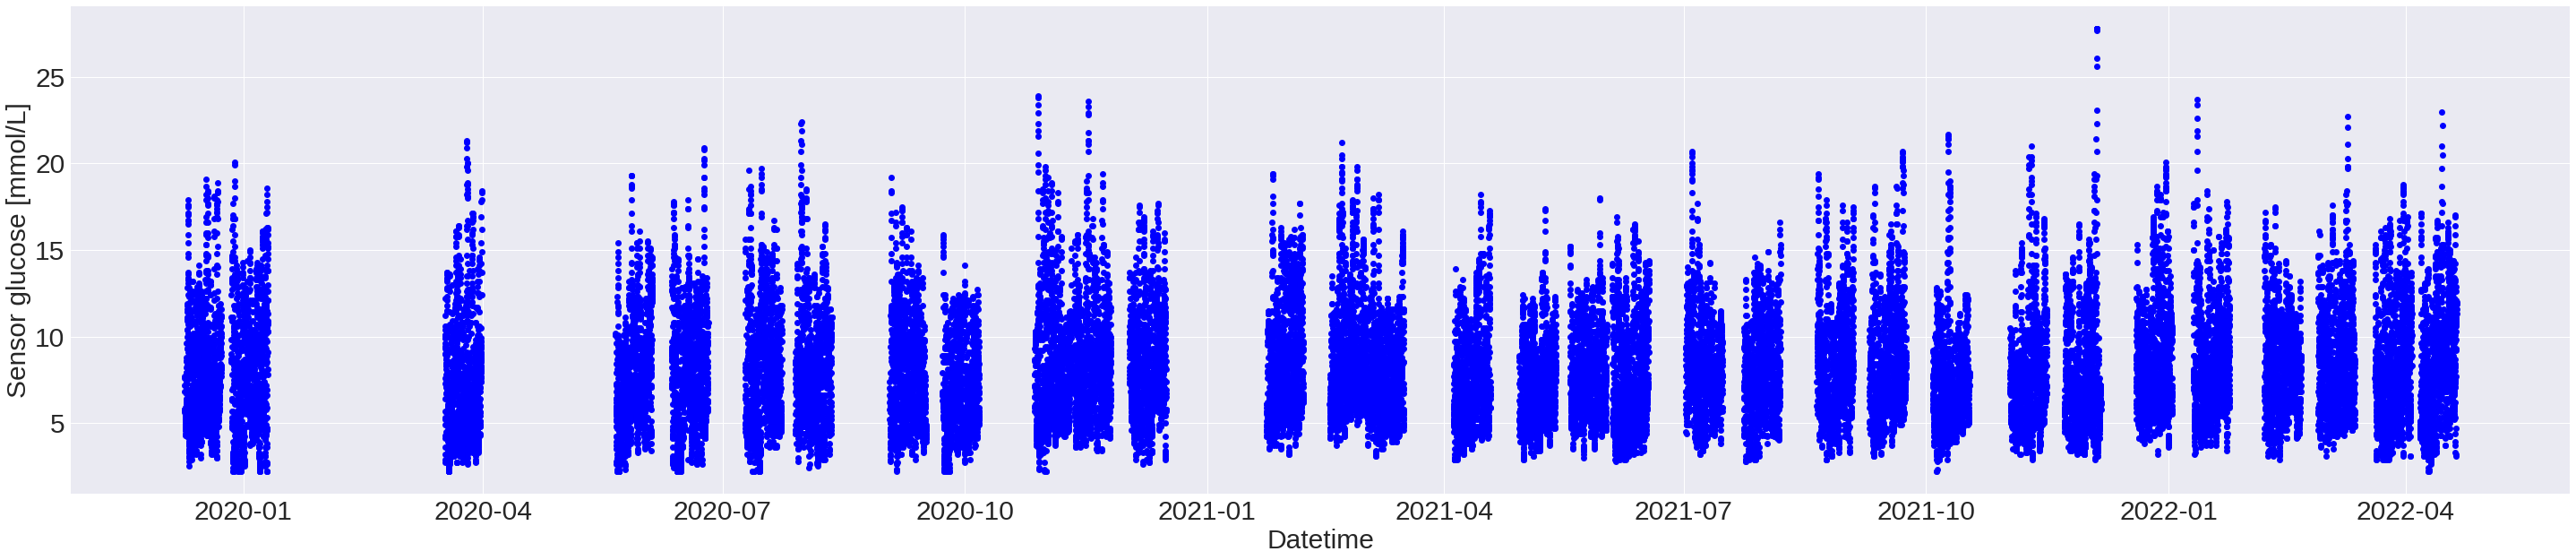

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(data['reading'], 'bo')
ax.set_xlabel('Datetime', fontsize=30)
ax.set_ylabel('Sensor glucose [mmol/L]', fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

# Setup hypo threshold and sanity check

In [7]:
HYPO_THRESHOLD = 3.9
data['is_hypo'] = (data['reading'] < HYPO_THRESHOLD).astype(int)

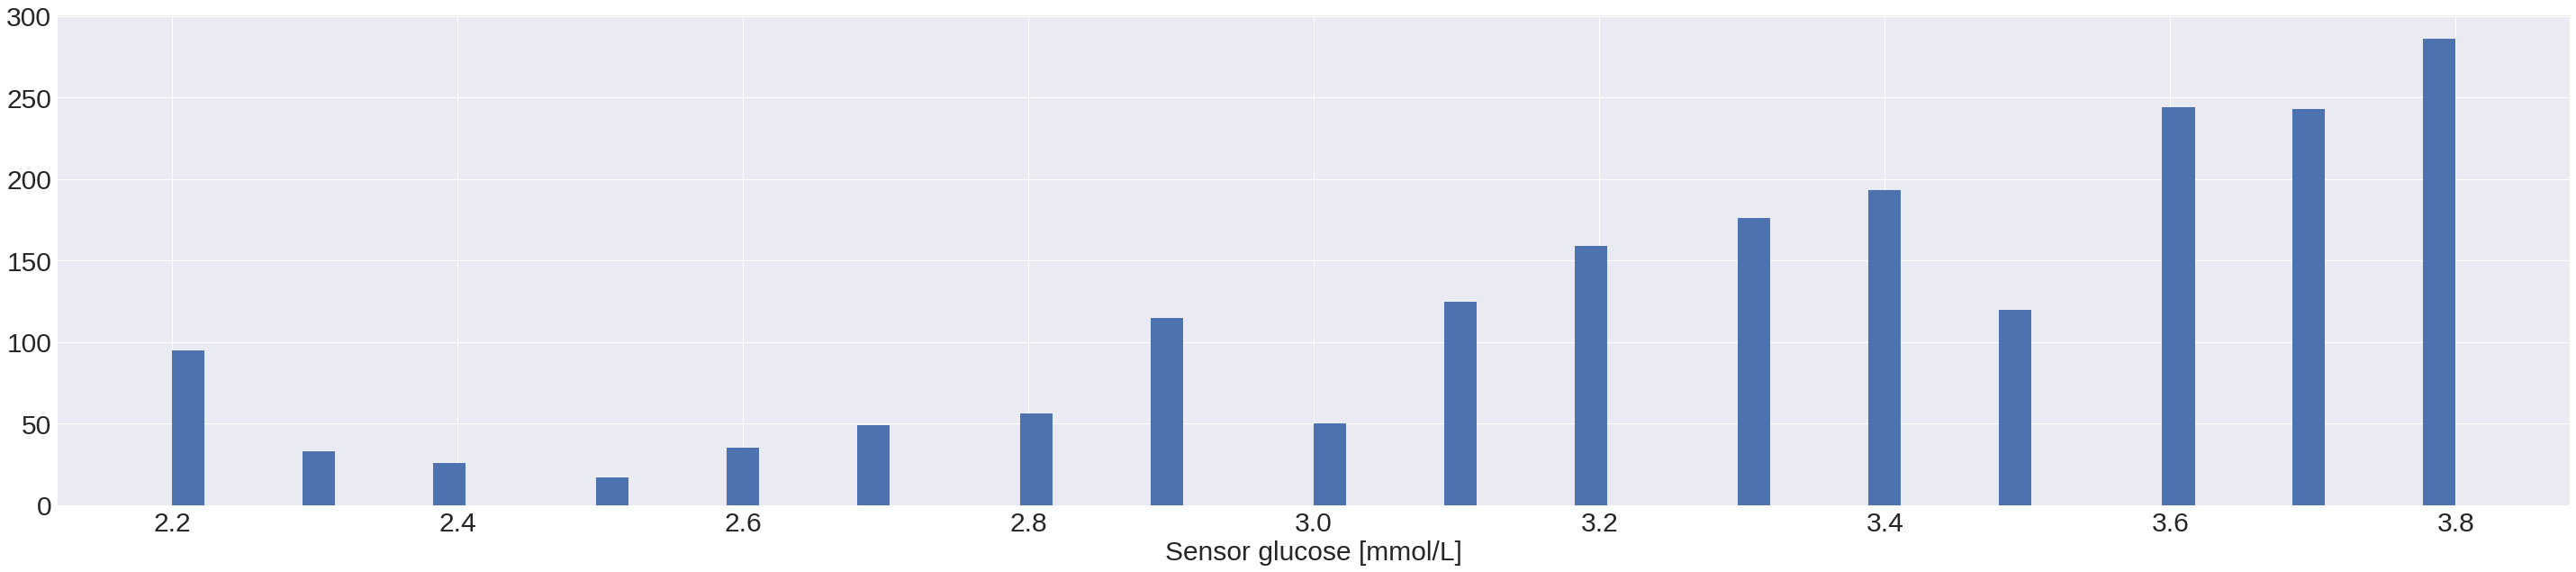

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.hist(data['reading'][data['is_hypo'] == 1], bins=70)
ax.set_xlabel('Sensor glucose [mmol/L]', fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

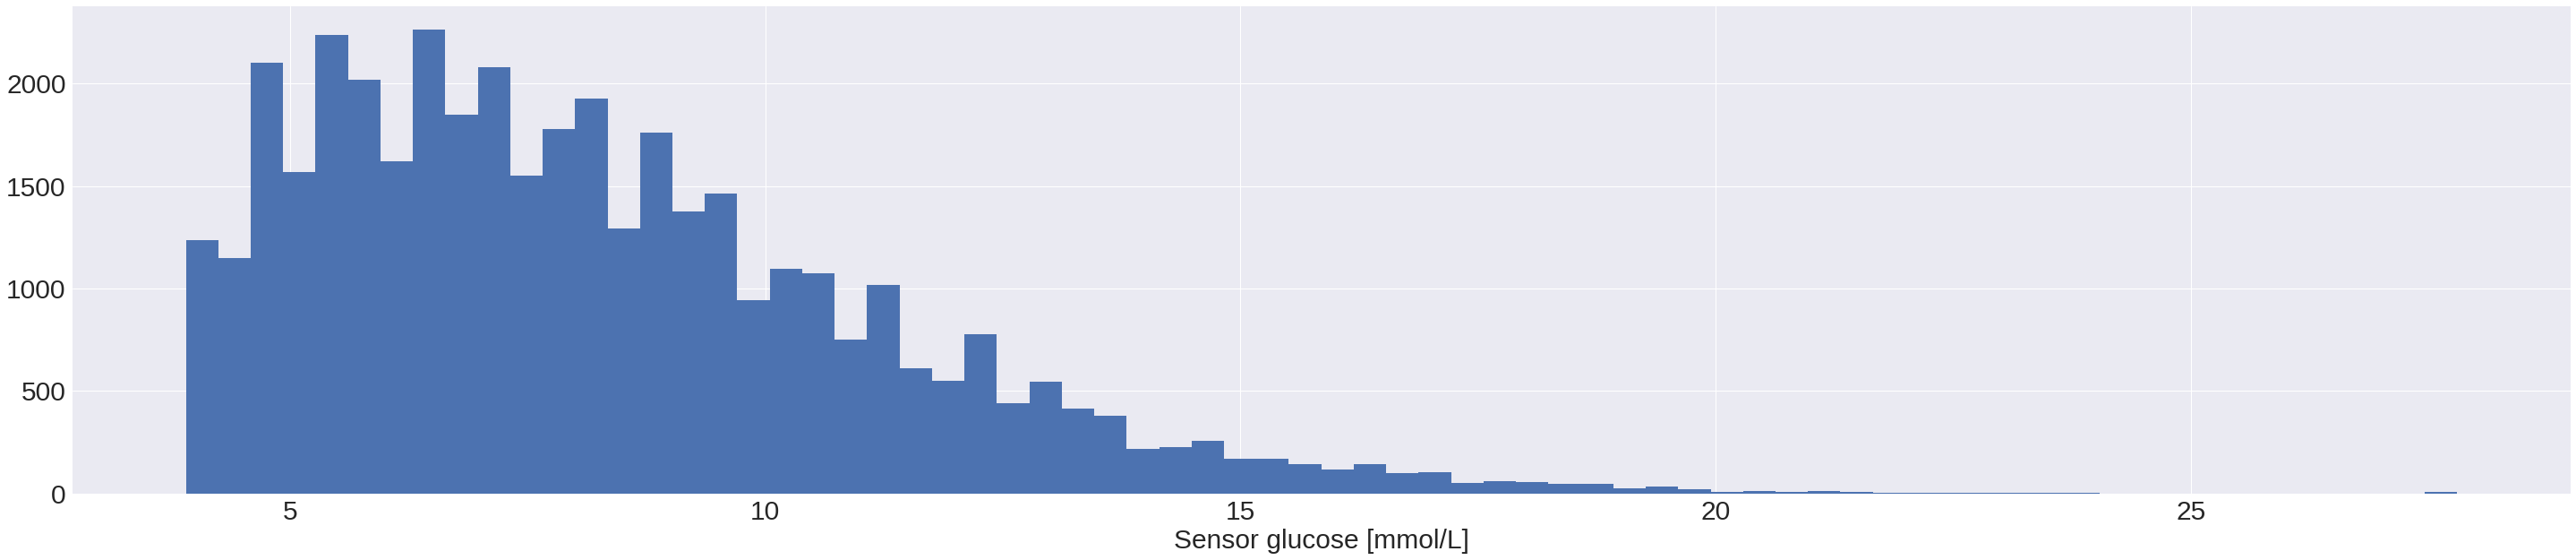

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.hist(data['reading'][data['is_hypo'] == 0], bins=70)
ax.set_xlabel('Sensor glucose [mmol/L]', fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

# class imbalance
* gallows humour:
    * This is going to be an extremely imbalanced dataset
    * If it were balanced, then I would probably be in hospital....

In [10]:
print(len(data[data['is_hypo'] == 1]) / len(data))
print(len(data[data['is_hypo'] == 0]) / len(data))

0.04818415784958536
0.9518158421504146


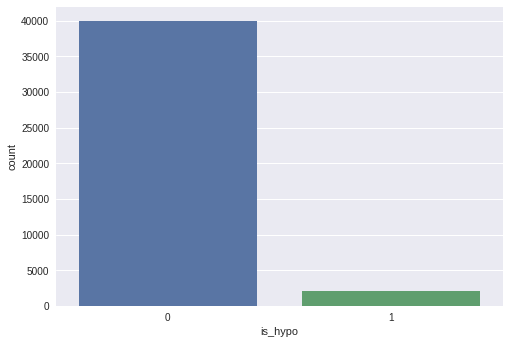

In [11]:
fig, ax = plt.subplots()
sns.countplot(x='is_hypo', data=data, ax=ax)

# variable exploration

In [12]:
# adding some time variables
data['hour'] = data.index.hour
data['day'] = data.index.dayofweek
data['month'] = data.index.month

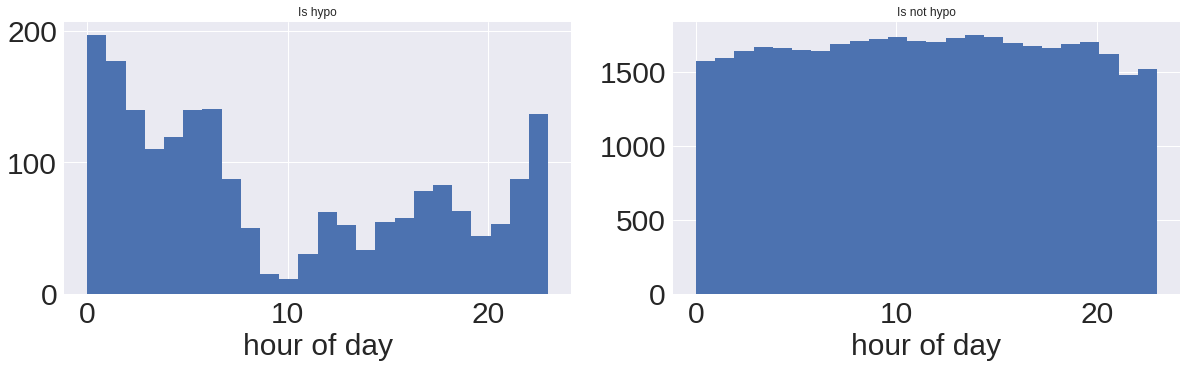

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(data['hour'][data['is_hypo'] == 1], bins=24)
ax[0].set_xlabel('hour of day', fontsize=30)
ax[0].tick_params(axis='x', labelsize=30)
ax[0].tick_params(axis='y', labelsize=30)
ax[0].set_title('Is hypo')

ax[1].hist(data['hour'][data['is_hypo'] == 0], bins=24)
ax[1].set_xlabel('hour of day', fontsize=30)
ax[1].tick_params(axis='x', labelsize=30)
ax[1].tick_params(axis='y', labelsize=30)
ax[1].set_title('Is not hypo')

plt.show()

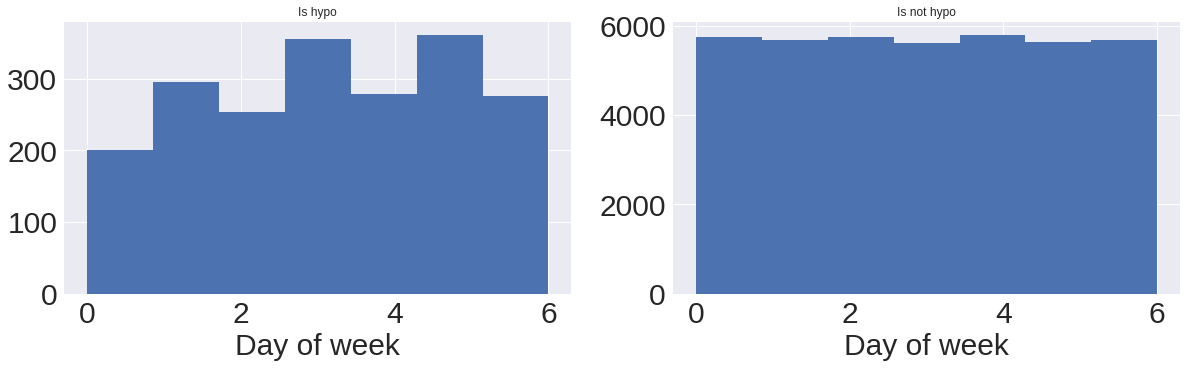

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(data['day'][data['is_hypo'] == 1], bins=7)
ax[0].set_xlabel('Day of week', fontsize=30)
ax[0].tick_params(axis='x', labelsize=30)
ax[0].tick_params(axis='y', labelsize=30)
ax[0].set_title('Is hypo')

ax[1].hist(data['day'][data['is_hypo'] == 0], bins=7)
ax[1].set_xlabel('Day of week', fontsize=30)
ax[1].tick_params(axis='x', labelsize=30)
ax[1].tick_params(axis='y', labelsize=30)
ax[1].set_title('Is not hypo')

plt.show()

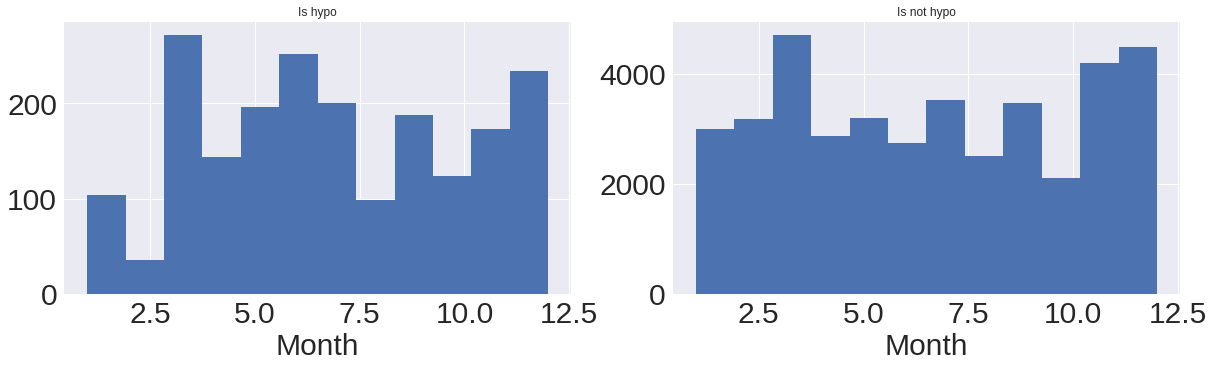

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(data['month'][data['is_hypo'] == 1], bins=12)
ax[0].set_xlabel('Month', fontsize=30)
ax[0].tick_params(axis='x', labelsize=30)
ax[0].tick_params(axis='y', labelsize=30)
ax[0].set_title('Is hypo')

ax[1].hist(data['month'][data['is_hypo'] == 0], bins=12)
ax[1].set_xlabel('Month', fontsize=30)
ax[1].tick_params(axis='x', labelsize=30)
ax[1].tick_params(axis='y', labelsize=30)
ax[1].set_title('Is not hypo')

plt.show()

# OneHotEncode hours

In [16]:
data = pd.get_dummies(data, prefix='hour', columns=['hour'])
print(data.columns)

Index(['reading', 'is_hypo', 'day', 'month', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')


# creating a lagged and rolling variables
* Was I hypo 15 mins ago? 30 mins ago? Etc
* Rolling average of last N readings
* Sign of gradient of last N readings:
    * I.e., is BG rising, falling, or stable?
    
## Lagged features

In [17]:
# create lags
# To ensure that we do not make a lag between periods of sensor non-usage, create a new df with the lagged indices & merge onto original data frame
def create_lag(df, lag):
    tolerance = 15 * lag
    freq = '15min'
    print(f'Creating lag of {tolerance} minutes')
    lagged_copy = df[['reading']].shift(lag, freq=freq)
    lagged_copy.rename(columns={'reading': f'lagged_reading_{lag}'}, inplace=True)
    
    merged = pd.merge_asof(df, lagged_copy, left_index=True, right_index=True, direction='backward', tolerance=pd.Timedelta(minutes=tolerance))
    # merged = pd.merge_asof(copy, lagged_copy, left_index=True, right_index=True, direction='backward')
    return merged

NLAGS = 8
for lag in range(1, NLAGS):
    data = create_lag(data, lag)

Creating lag of 15 minutes
Creating lag of 30 minutes
Creating lag of 45 minutes
Creating lag of 60 minutes
Creating lag of 75 minutes
Creating lag of 90 minutes
Creating lag of 105 minutes


In [18]:
data.head(15)

,reading,is_hypo,day,month,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,...,hour_21,hour_22,hour_23,lagged_reading_1,lagged_reading_2,lagged_reading_3,lagged_reading_4,lagged_reading_5,lagged_reading_6,lagged_reading_7
Device Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-09 19:04:00,6.8,0,0,12,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-09 19:20:00,7.6,0,0,12,0,0,0,0,0,0,...,0,0,0,6.8,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-09 19:35:00,7.7,0,0,12,0,0,0,0,0,0,...,0,0,0,7.6,6.8,NaN,NaN,NaN,NaN,NaN
2019-12-09 19:50:00,7.2,0,0,12,0,0,0,0,0,0,...,0,0,0,7.7,7.6,6.8,NaN,NaN,NaN,NaN
2019-12-09 20:05:00,5.8,0,0,12,0,0,0,0,0,0,...,0,0,0,7.2,7.7,7.6,6.8,NaN,NaN,NaN
2019-12-09 20:20:00,5.6,0,0,12,0,0,0,0,0,0,...,0,0,0,5.8,7.2,7.7,7.6,6.8,NaN,NaN
2019-12-09 20:36:00,5.8,0,0,12,0,0,0,0,0,0,...,0,0,0,5.6,5.8,7.2,7.7,7.6,6.8,NaN
2019-12-09 20:51:00,5.8,0,0,12,0,0,0,0,0,0,...,0,0,0,5.8,5.6,5.8,7.2,7.7,7.6,6.8
2019-12-09 21:06:00,5.7,0,0,12,0,0,0,0,0,0,...,1,0,0,5.8,5.8,5.6,5.8,7.2,7.7,7.6


# Checks
* check periods where I was not wearing the sensor!
* I stopped wearing on 10/1/20 and restarted on 17/3/20, for example
* Want to avoid this

```
merged['2020-01-10'].iloc[-1]['reading']
merged['2020-03-17'].iloc[0]['previous_reading']
7.8
7.8
```
* I.e. the last reading on 10/1/20 is used as "previous_reading" on 17/3/20

In [19]:
print(data['2020-01-10'].iloc[-1]['reading'])
print(data['2020-03-17'].iloc[0]['lagged_reading_1'])
print(data['2020-03-17'].iloc[1]['lagged_reading_2'])
print(data['2020-03-17'].iloc[2]['lagged_reading_3'])
print(data['2020-03-17'].iloc[3]['lagged_reading_4'])

7.8
nan
nan
nan
nan


/tmp/ipykernel_3837/377992117.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(data['2020-01-10'].iloc[-1]['reading'])
/tmp/ipykernel_3837/377992117.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(data['2020-03-17'].iloc[0]['lagged_reading_1'])
/tmp/ipykernel_3837/377992117.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  print(data['2020-03-17'].iloc[1]['lagged_reading_2'])
/tmp/ipykernel_3837/377992117.py:4: FutureWarning: Indexing a DataFrame with a datetimelike i

In [20]:
# For ease of variable calculation, drop the nans
data = data.dropna()

In [21]:
# lagged hypo bools
for lag in range(1, NLAGS):
    data[f'is_lagged_hypo_{lag}'] = (data[f'lagged_reading_{lag}'] < HYPO_THRESHOLD).astype(int)

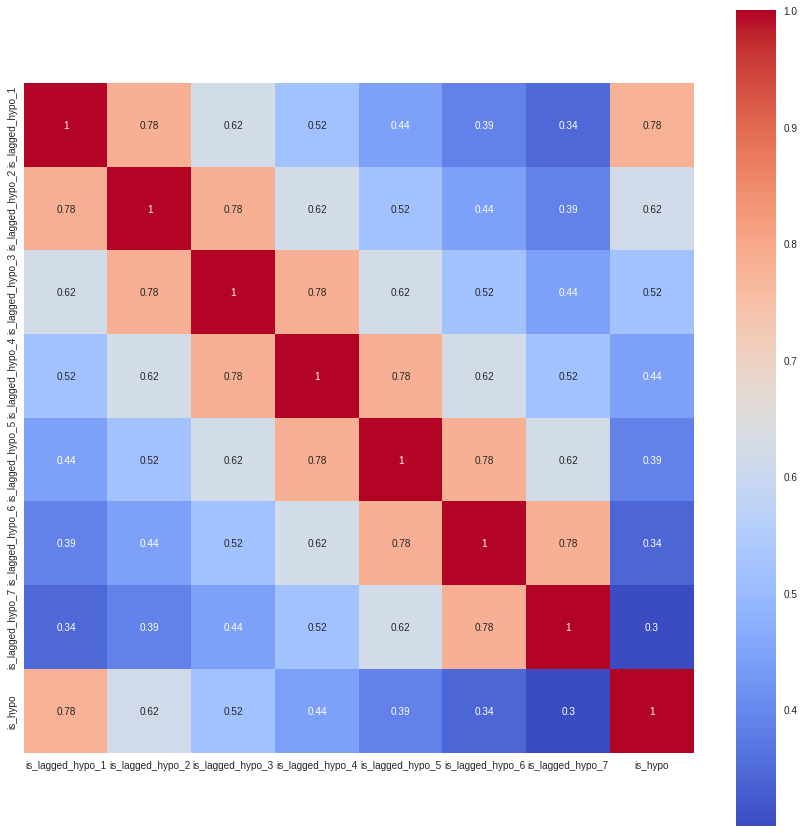

In [22]:
cols = [f'is_lagged_hypo_{v}' for v in range(1, NLAGS)]
cols.append('is_hypo')
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(data[cols].corr(), cmap=cmap, annot=True, square=True, ax=ax)

plt.show()

## Rolling features

In [23]:
# simple differences of lags - was reading higher, lower, or stable?
for lag in range(2, NLAGS):
    data[f'diff_{lag}'] = data['lagged_reading_1'] - data[f'lagged_reading_{lag}']

# gradients - how quick is BG changing?
interval = 15
for lag in range(2, NLAGS):
    data[f'rate_{lag}'] = data[f'diff_{lag}'] / (interval * lag)

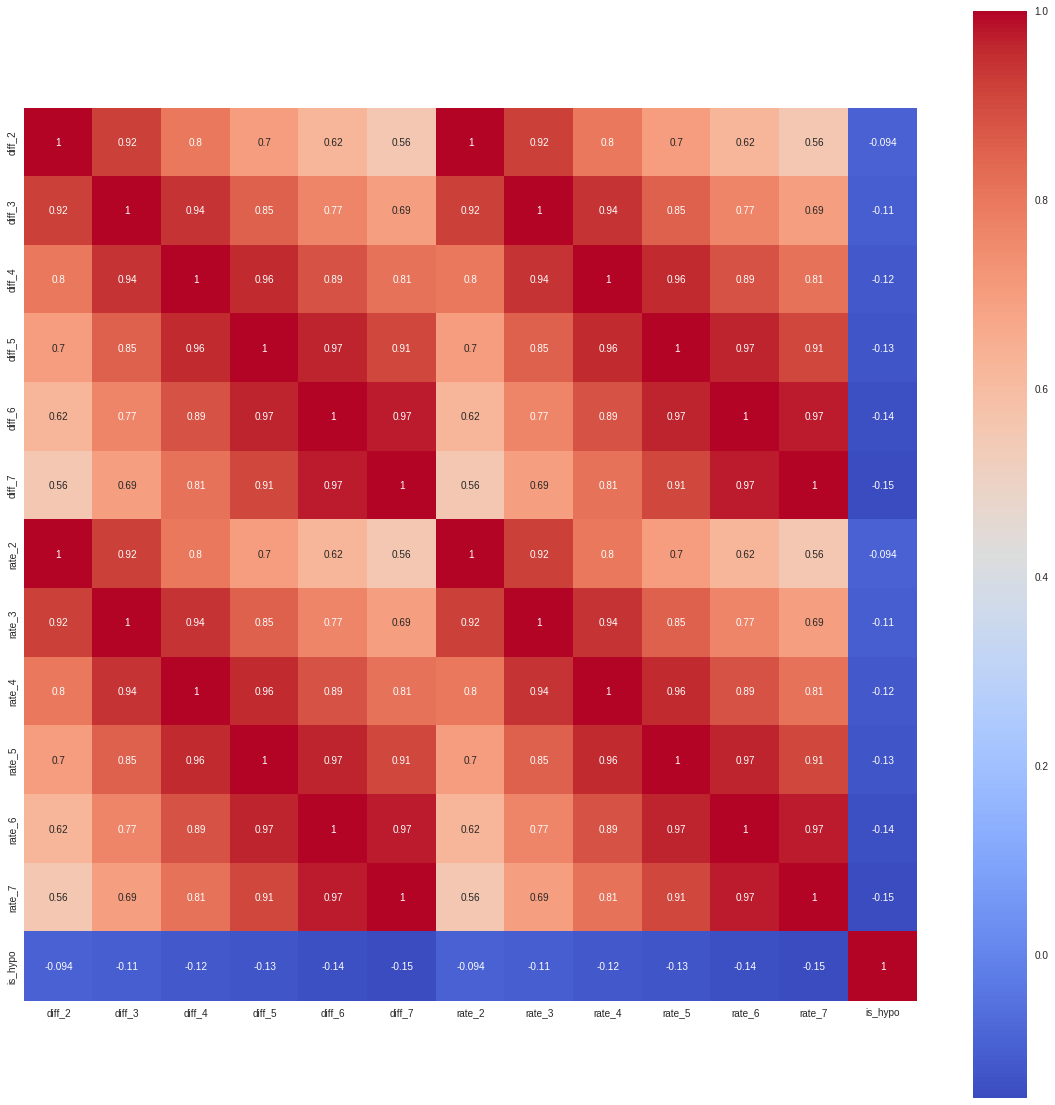

In [24]:
cols = [f'diff_{v}' for v in range(2, NLAGS)]
cols.extend([f'rate_{v}' for v in range(2, NLAGS)])
cols.append('is_hypo')
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(data[cols].corr(), cmap=cmap, annot=True, square=True, ax=ax)

plt.show()

## train, test, validation split

In [25]:
TRAIN_SPLIT = 0.65
VAL_SPLIT = 0.2
TEST_SPLIT = 0.15

In [26]:
itrain = int(TRAIN_SPLIT * len(data))
ival = int(VAL_SPLIT * len(data))
itest = int(TEST_SPLIT * len(data))

train_data = data.iloc[:itrain]
val_data = data.iloc[itrain:itrain + ival]
test_data = data.iloc[itrain + ival:]

# Checking length and dates

In [27]:
print(len(data))

print(len(train_data))
print(len(val_data))
print(len(test_data))

print(len(train_data) + len(val_data) + len(test_data))

print(train_data.index[0], train_data.index[-1])
print(val_data.index[0], val_data.index[-1])
print(test_data.index[0], test_data.index[-1])

41231
26800
8246
6185
41231
2019-12-09 20:51:00 2021-08-04 10:43:00
2021-08-04 10:59:00 2022-01-13 19:57:00
2022-01-13 20:12:00 2022-04-20 09:40:00


# Class imbalance in splits

In [28]:
print(len(train_data[train_data['is_hypo'] == 1]) / len(train_data))
print(len(train_data[train_data['is_hypo'] == 0]) / len(train_data))

print(len(val_data[val_data['is_hypo'] == 1]) / len(val_data))
print(len(val_data[val_data['is_hypo'] == 0]) / len(val_data))

print(len(test_data[test_data['is_hypo'] == 1]) / len(test_data))
print(len(test_data[test_data['is_hypo'] == 0]) / len(test_data))

0.05559701492537313
0.9444029850746268
0.036138733931603204
0.9638612660683968
0.03265966046887631
0.9673403395311236


# Baseline model

Accuracy: 0.9631366208569119
Precision: 0.43564356435643564
Recall: 0.43564356435643564
F1: 0.43564356435643564


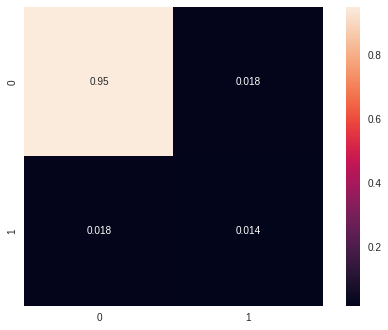

In [29]:
# Simplest thing to do, was I hypo 45 mins ago?
y_baseline_test = test_data['is_hypo']
y_baseline_pred = test_data['is_lagged_hypo_3']

# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
print(f'Accuracy: {accuracy_score(y_baseline_test, y_baseline_pred)}')
print(f'Precision: {precision_score(y_baseline_test, y_baseline_pred)}')
print(f'Recall: {recall_score(y_baseline_test, y_baseline_pred)}')
print(f'F1: {f1_score(y_baseline_test, y_baseline_pred)}')

cm = confusion_matrix(y_baseline_test, y_baseline_pred, normalize='all')
sns.heatmap(cm, annot=True, square=True)

# These results clearly illustrate the class imbalance challenge
* May need to investigate upweighting the positive classes?

# Variable selection

In [30]:
rates_and_diffs = [f'diff_{v}' for v in range(2, NLAGS)]
rates_and_diffs.extend([f'rate_{v}' for v in range(2, NLAGS)])

# to fairly compare with baseline, drop any historical variables with time delta < 45 mins
vars_to_drop = [
    'month',
    'day',
    'reading',
    'is_lagged_hypo_1',
    'is_lagged_hypo_2',
    'lagged_reading_1',
    'lagged_reading_2',
]
vars_to_drop.extend(rates_and_diffs)

train_data = train_data.drop(vars_to_drop, axis='columns')
val_data = val_data.drop(vars_to_drop, axis='columns')
test_data = test_data.drop(vars_to_drop, axis='columns')

print(train_data.columns)
print(val_data.columns)
print(test_data.columns)

Index(['is_hypo', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'lagged_reading_3', 'lagged_reading_4', 'lagged_reading_5',
       'lagged_reading_6', 'lagged_reading_7', 'is_lagged_hypo_3',
       'is_lagged_hypo_4', 'is_lagged_hypo_5', 'is_lagged_hypo_6',
       'is_lagged_hypo_7'],
      dtype='object')
Index(['is_hypo', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'lagged_reading_3', 'lagged_reading_4', 'lagged_reading_5',
       'lagged_reading_6', 'lagged_reading_7', 'is_lagged_hypo_3',
       'is_lagged_hypo_4', 'i

In [31]:
target = 'is_hypo'

X_train = train_data.drop([target], axis='columns')
y_train = train_data[target]

X_val = val_data.drop(target, axis='columns')
y_val = val_data[target]

X_test = test_data.drop(target, axis='columns')
y_test = test_data[target]

print(X_train.columns)

Index(['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'lagged_reading_3', 'lagged_reading_4', 'lagged_reading_5',
       'lagged_reading_6', 'lagged_reading_7', 'is_lagged_hypo_3',
       'is_lagged_hypo_4', 'is_lagged_hypo_5', 'is_lagged_hypo_6',
       'is_lagged_hypo_7'],
      dtype='object')


# XGBoost

In [65]:
# compute class weights to balance dataset
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train.to_numpy())
# print(class_weights)

weights_dict = {i: v for i, v in enumerate(class_weights)}
sample_weights = y_train.copy(deep=True)
sample_weights = sample_weights.map(weights_dict)
# print(sample_weights)

xgb_weight = float(y_train[y_train == 0].count()) / y_train[y_train == 1].count()
print(xgb_weight)

16.986577181208055


In [80]:
# define model
from xgboost import XGBClassifier
model = XGBClassifier(
    #verbosity=2,
    n_estimators=300,
    # eta=0.3,
    eta=0.15,
    gamma=0,
    max_depth=6,
    reg_lambda=1,
    reg_alpha=0,
    subsample=0.5,
    scale_pos_weight=xgb_weight,
    objective='binary:logistic'   
)

In [81]:
# fit model
model.fit(
    X_train,
    y_train,
    eval_metric=['aucpr', 'logloss'],
    eval_set=[(X_train, y_train), (X_val, y_val)],
    early_stopping_rounds=15,
    #verbose=True
    verbose=False
)

/home/sdysch/.local/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/sdysch/.local/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.15,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.150000006, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

/tmp/ipykernel_3837/2300142190.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


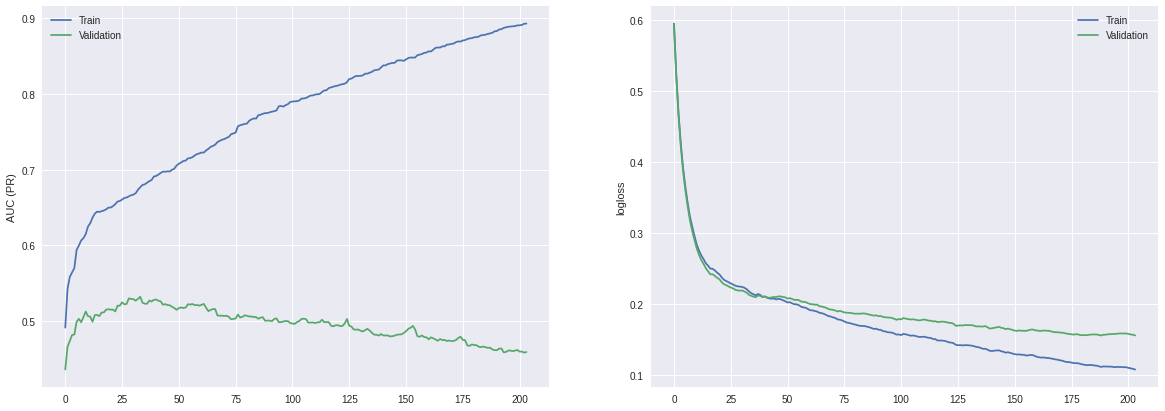

In [82]:
results = model.evals_result()

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(results['validation_0']['aucpr'], label='Train')
ax[0].plot(results['validation_1']['aucpr'], label='Validation')
ax[0].legend(loc='best')
ax[0].set_ylabel('AUC (PR)')

ax[1].plot(results['validation_0']['logloss'], label='Train')
ax[1].plot(results['validation_1']['logloss'], label='Validation')
ax[1].legend(loc='best')
ax[1].set_ylabel('logloss')


fig.show()

Accuracy: 0.9351657235246564
Precision: 0.2702078521939954
Recall: 0.5792079207920792
F1: 0.36850393700787404


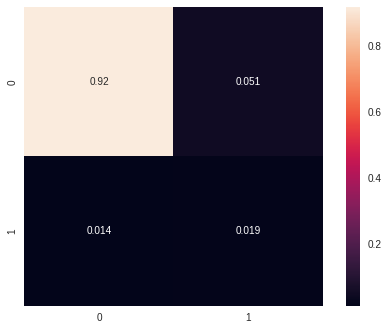

In [83]:
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred, normalize='all')
sns.heatmap(cm, annot=True, square=True)

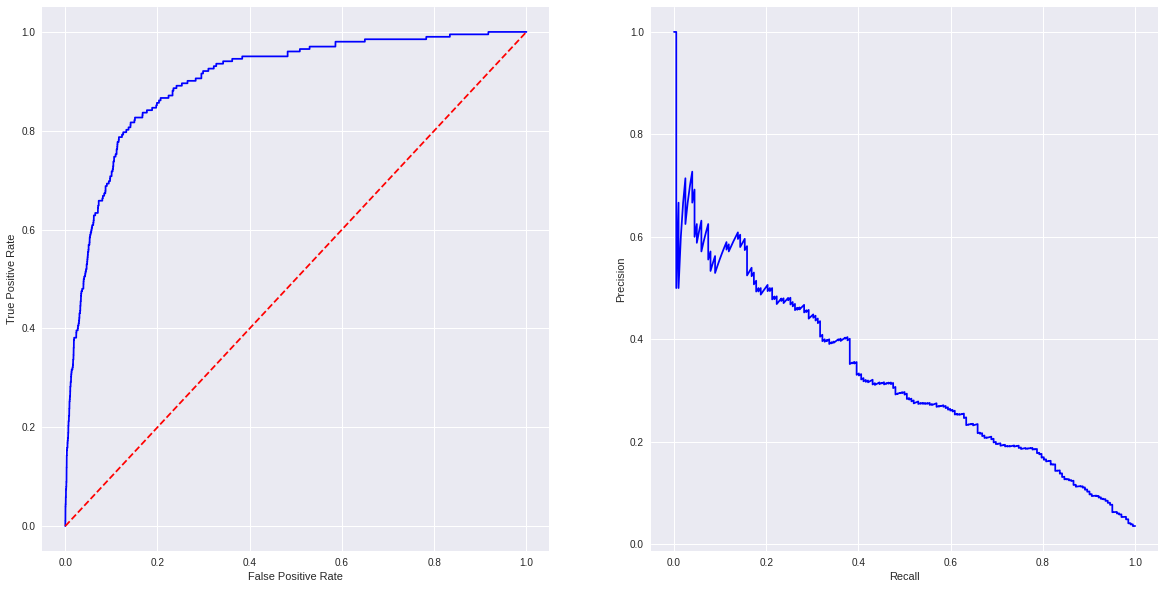

0.9029395167496025


In [120]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
y_pred_prob = model.predict_proba(X_test)[:, 1]

# fpr, tpr, _ = roc_curve(y_test, y_pred)
# precision, recall, _ = precision_recall_curve(y_test, y_pred)

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(fpr, tpr, 'b')
ax[0].plot([0, 1], [0, 1], 'r--')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')

ax[1].plot(recall, precision, 'b')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')

plt.show()
roc_auc = auc(fpr, tpr)
print(roc_auc)